# Notebook to compute relative errors in the accelerations computed with Gadget and BFE

## TODO

- Look at the acceleration for a particlar particle
- How does the acceleration error changes with the epxansion length
- What about centering ? 

In [273]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('/mnt/home/nico/matplotlib.mplstyle')
from matplotlib.colors import LogNorm
import linecache
import sys

# Astropy 
import astropy
from astropy.constants import Constant
import astropy.constants as const
import astropy.units as u
import numpy as np

G_unit = u.m**3 / u.kg / u.s**2
astropy.constants.G = Constant(
    'G', 
    'Gravitational constant',
    (1 * u.kpc * u.km**2 / u.s**2 / u.Msun / 1E10 ).to_value(G_unit),
    'm3 / (kg s2)',
    np.nan, 
    system='si',
    reference='GADGET'
)





# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic
from gala.potential.scf import compute_coeffs_discrete, SCFPotential

# Third party
sys.path.append("../../../BFE_integrator/src/")
sys.path.append("../../bfe_gala_orbits/notebooks/")

#from orbit_gala_script import get_center
#from read_coefficients import load_scf_coefficients


import nba
from nba.ios import load_halo
from nba.ios import load_snapshot
from nba.com.com_routines import shrinking_sphere

import pynbody
from bfe.ios import read_coefficients
from bfe_fields import BFE_fields

from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


In [10]:
from pynbody.analysis.halo import shrink_sphere_center as ssc

In [49]:
# const.G
G_gadget = 43007.1 * (u.kpc * u.km**2 / u.s**2 / u.Msun / 1E10 )

In [12]:
## 
def load_coefficients(coeff_path, coeff_name, centers_path, snap_params, exp_length, exp_params):
    
    
    # Snapshots parameters
    dt = snap_params[0] #0.02
    init_snap = snap_params[1] #500
    final_snap = snap_params[2]
    nsnaps_nbody = final_snap - init_snap + 1
    
    # Coefficients parameters
    nmax = exp_length[0] # 15
    lmax = exp_length[1] #5
    mmax = exp_length[2] #5
    
    # Expansion parameters 
    rs_halo = exp_params[0] #20
    pm =  exp_params[1] #  2.334E-4 #/ 0.999 # particle mass in N-body sims
    sn_cut = exp_params[2] # 5
    
    
    #n_orbits = 730 # in the N-body file
    #HR = 100.0
    #p_orbit = 1 # Which orbit to use from the N-body code  
    #t_orbit = np.arange(0, nsnaps_nbody*dt, dt)
    #t_orbit2 = np.arange(0, nsnaps_nbody*dt, dt/HR)
   
    #coeff_path_centers = '/mnt/home/nico/projects/bfe_computation/examples/runing_pipeline/BFE_LMC5_grav_MO5_ss_COM_n15_l5_host_snap'
    #path_to_coeff = "../../../projects/bfe_computation/examples/runing_pipeline/"
    #coeff_file = "BFE_LMC5_grav_MO5_ss_COM_n15_l5_host_snap_"
    
    S_scf = np.zeros((nsnaps_nbody, nmax+1, lmax+1, mmax+1))
    T_scf = np.zeros((nsnaps_nbody, nmax+1, lmax+1, mmax+1))

    rcom_all = np.zeros((int(nsnaps_nbody), 3))
    vcom_all = np.zeros((int(nsnaps_nbody), 3))
    
    i = 0
    for i in range(init_snap, final_snap):
        rcom_all[i], vcom_all[i] = get_center(coeff_path_centers+'_{:03d}.txt'.format(i))
        S_scf[i], T_scf[i] = load_scf_coefficients(path_to_coeff + coeff_file + "{:03d}.txt".format(i), nmax, lmax, mmax, pm, sn=sn_cut)
        i+=1
    return S_scf, T_scf

In [520]:
def acceleration_diff(d, a1, a2, figname, da_limits, ylabel):
    """
    returns a1-a2  / a2
    """
    a_dif = np.sqrt(np.sum((a1-a2)**2, axis=1))/ np.sqrt(np.sum(a2**2, axis=1))
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    h  = np.histogram2d(d, a_dif, bins=100)
    im = ax.imshow(h[0].T, cmap='bone_r', norm=LogNorm(), origin='lower', 
                   aspect='auto', extent=[np.min(d), np.max(d), np.min(a_dif), np.max(a_dif)])
    fig.colorbar(im)
    ax.set_ylim(da_limits[0], da_limits[1])
    ax.set_xscale('log')
    ax.set_xlabel(r'$r\rm{[kpc]}$')
    ax.set_ylabel(ylabel)
    savefig(figname, bbox_inches='tight')
    return a_dif

In [14]:
# Forcetest_file 

def get_direct_acceleration(file_path, N_lines, sample_lines=1000000, skip_footer=True):
    #file_path = '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/forcetest.txt'
    #N_lines = 63229293 
    if skip_footer == True:
        force_test = np.genfromtxt(file_path, skip_header=0, skip_footer=N_lines - sample_lines)
    else:
        force_test = np.genfromtxt(file_path, skip_header=0)
    time = force_test[:,3]
    pos = force_test[:,4:7]
    a_direct = force_test[:,8:11]
    a_fmm = force_test[:,11:14]
    #dist = np.sqrt(np.sum(pos**2, axis=1))
    del(force_test)
    return time, pos, a_direct, a_fmm

In [7]:
!wc -l '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/forcetest.txt'

63229293 /mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/forcetest.txt


In [8]:
!head -1 '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/forcetest.txt'


1 0 4362261 0      7.26451826096    -4.33303308487      7.6756749153      104.237640386     -497.514736346     295.093281131    -524.619867643     -497.512357596     295.128648952    -524.588138953     -24614.8395351     -24614.610143


In [158]:
## Mass factor
snap_name = '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/LMC5_15M_vir_eps_100pc_ics2_grav_MO3_000'
pos_halo = load_snapshot(snap_name, snapformat=3, quantity='pos', ptype='dm')
mass_halo = load_snapshot(snap_name, snapformat=3, quantity='mass', ptype='dm')

Loading 'Coordinates' of particles types 'PartType1' from snapshot: '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/LMC5_15M_vir_eps_100pc_ics2_grav_MO3_000.hdf5'
Loading 'Masses' of particles types 'PartType1' from snapshot: '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/LMC5_15M_vir_eps_100pc_ics2_grav_MO3_000.hdf5'


In [145]:
index_cut = np.where(np.sqrt(np.sum(pos_halo**2, axis=1))<400)

In [146]:
len(index_cut[0])/15000000 

0.907802

In [160]:
np.sum(mass_halo)

17.995384

In [358]:
np.sum(mass_halo[index_cut])

16.336128

In [359]:
16.336/17.99

0.9080600333518621

In [166]:
halo_s = nba.structure.Structure(pos_halo, mass_halo)

In [168]:
rh, mp = halo_s.enclosed_mass(100, 0, 400)

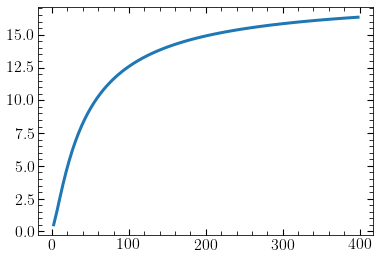

In [169]:
plot(rh, mp)

In [341]:
def hernquist_halo(x, m):
    h_gala = gp.HernquistPotential(m=m, c=20, units=galactic)
    mc = h_gala.mass_enclosed(x)
    return mc.value

In [342]:
xyz = np.zeros((3, 99))
xyz[0] = rh

In [343]:
curve_fit(hernquist_halo, xyz, mp, bounds=(16, 25))

(array([18.06841285]), array([[0.00032606]]))

In [355]:
h_gala = gp.HernquistPotential(m=18.06, c=20., units=galactic)
mc = h_gala.mass_enclosed(xyz)


h_gala2 = gp.HernquistPotential(m=17.99*0.907802, c=20, units=galactic)
mc2 = h_gala2.mass_enclosed(xyz)

In [356]:
17.99*0.9/17.8586

0.9066220196431971

[]

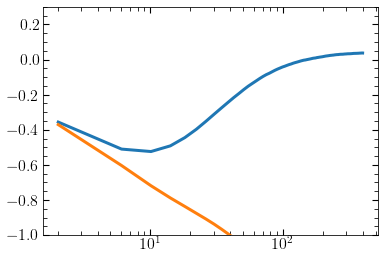

In [357]:
plot(rh, mc.value- mp)
plot(rh, mc2.value-mp)

#plot(rh, mp)
ylim(-1, 0.3)
semilogx()

In [ ]:
curve_fit()

## 1. Direct acceleration vs FMM vs BFE

### Isolated halo 

In [15]:
# Simulations isolated halo acccelerations
acceleration_file = '../../../BFE_integrator/notebooks/iso_halo_MO3_forcetest.txt'
time_a, pos_a, a_direct, a_fmm = get_direct_acceleration(acceleration_file, N_lines=100000)

a_direct_mag = np.sqrt(np.sum(a_direct**2, axis=1))
a_fmm_mag = np.sqrt(np.sum(a_fmm**2, axis=1))
dist = np.sqrt(np.sum(pos_a**2, axis=1))
dcut = np.where((dist>5) & (dist<500))

In [ ]:
#!wc -l '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/forcetest.txt'

In [ ]:
#! head -1000000 /mnt/home/nico/ceph/MWLMC_sims/ICs/MW/MO3/forcetest.txt > mw_MO3_forcetest.txt

In [365]:
path_to_coeff = "/mnt/home/nico/projects/time-dependent-BFE/data/iso_softening_100pc_grav_MO3/BFE_LMC5_grav_MO3_ssc_COM_n40_20_host_snap_000"

coeff_iso, exp_length, snap_params, iso_rcom = read_coefficients(path_to_coeff)
S_scf_iso = coeff_iso[0]
T_scf_iso = coeff_iso[1]

<KeysViewHDF5 ['G', 'Snlm', 'Tnlm', 'lmax', 'mmax', 'nmax', 'pmass', 'rcom', 'rs']>
* Loading coefficients


In [366]:
np.shape(S_scf_iso)

(41, 21, 21)

In [367]:
## Isolated halo 
halo = gp.scf.SCFPotential(m=1e10*u.Msun, r_s=snap_params[0]*u.kpc, Snlm=S_scf_iso, Tnlm=T_scf_iso, units=galactic)


In [368]:
np.shape(pos_a[dcut])

(899754, 3)

In [369]:
halo.G

4.498502151469553e-12

In [370]:
halo.G=1

In [371]:
a_bfe = halo.acceleration(pos_a[dcut][:10000].T).to(u.kpc/u.Gyr**2).value

In [408]:
a_mybfe  = BFE_fields(pos_a[dcut][:10000], S_scf_iso, T_scf_iso, snap_params[0], 
                      exp_length[0], exp_length[1], G=G_gadget,
                     M=1e10)

In [409]:
a_bfe_my = a_mybfe.bfe_acceleration()

In [404]:
np.array(a_bfe_my)

array([[ 49.68093144,  51.73780442,  56.02715446, ...,   0.86513664,
          4.95605301,  52.27215481],
       [-29.1462135 , -31.34479711, -38.84536119, ..., -23.38377129,
        -30.11035062,  18.70558869],
       [ 52.52269341,  52.99876396,  51.64573559, ..., -63.81512631,
        -64.21488162, -17.95748538]])

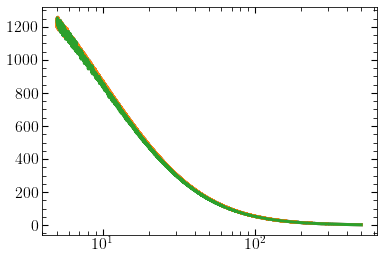

In [531]:
sort_d = np.argsort(dist[dcut])
sort_d2 = np.argsort(dist[dcut][:10000])

plot(dist[dcut][sort_d], np.sqrt(np.sum(a_fmm[dcut]**2, axis=1))[sort_d])
plot(dist[dcut][sort_d], np.sqrt(np.sum(a_direct[dcut]**2, axis=1))[sort_d])
plot(dist[dcut][sort_d2], np.sqrt(np.sum(np.array(a_bfe_my)**2, axis=0))[sort_d2]*0.94)

xscale('log')

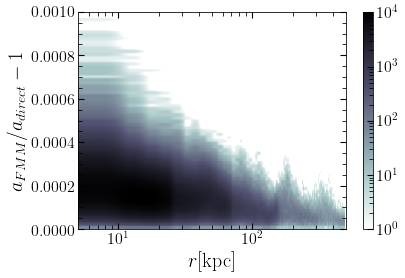

In [529]:
a_dif_direct_fmm = acceleration_diff(dist[dcut], a_direct[dcut], a_fmm[dcut], '/mnt/home/nico/Documents/gadget_acc_errors.png', [0, 1E-3],
                                    '$a_{FMM} /a_{direct} - 1$')


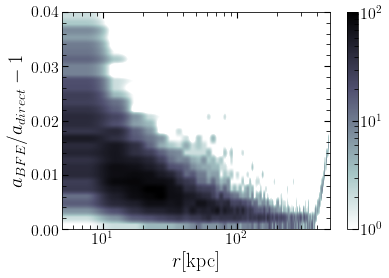

In [538]:
a_dif_direct_bfe = acceleration_diff(dist[dcut][:10000], -a_direct[dcut][:10000], np.array(a_bfe_my).T*0.956, '/mnt/home/nico/Documents/test_BFE_acc_errors.png', [0, 0.04],
                                     '$a_{BFE} /a_{direct} - 1$')

In [364]:
a_dif_direct_bfe = acceleration_diff(dist[dcut], a_direct[dcut], a_bfe.T, 'BFE_acc_errors_n20_l20.png', [0, 0.1],
                                     '$a_{BFE} /a_{direct} - 1$')

ValueError: operands could not be broadcast together with shapes (899754,3) (10000,3) 

## Isolated MW halo 


In [578]:
!tail -1000000 /mnt/home/nico/ceph/MWLMC_sims/ICs/MW/MO3/forcetest.txt > ../../../time-dependent-BFE/scripts/acceleration_errors/tail_mw_MO3_forcetest.txt


In [579]:
# Simulations isolated MW acccelerations


#acceleration_file_mw = '/mnt/home/nico/ceph/MWLMC_sims/ICs/MW/MO3/forcetest.txt'
#acceleration_file_mw = '../../../BFE_integrator/notebooks/mw_MO3_forcetest.txt'
acceleration_file_mw = '../../../time-dependent-BFE/scripts/acceleration_errors/tail_mw_MO3_forcetest.txt'

time_mw_a, pos_mw_a, a_mw_direct, a_mw_fmm = get_direct_acceleration(acceleration_file_mw, N_lines=1000000, skip_footer=False)

a_mw_direct_mag = np.sqrt(np.sum(a_mw_direct**2, axis=1))
a_mw_fmm_mag = np.sqrt(np.sum(a_mw_fmm**2, axis=1))
dist_mw = np.sqrt(np.sum(pos_mw_a**2, axis=1))
dcut_mw = np.where((dist_mw>5) & (dist_mw<500))

In [583]:
time_mw_a[-1]

1.6748

In [441]:
path_to_coeff = "/mnt/home/nico/projects/time-dependent-BFE/data/expansion/MW2_100M_beta1_vir_OM3_G4/BFE_MW_grav_MO3_ssc_COM_host_snap_000"

coeff_mw, mw_exp_length, mw_snap_params, mw_rcom = read_coefficients(path_to_coeff)
S_scf_mw = coeff_mw[0]
T_scf_mw = coeff_mw[1]

<KeysViewHDF5 ['G', 'Snlm', 'Tnlm', 'lmax', 'mmax', 'nmax', 'pmass', 'rcom', 'rs']>
* Loading coefficients


In [469]:
mw_potential = gp.CCompositePotential()
rs_halo = mw_snap_params[0]
print(rs_halo)
#mw_potential.G = 4.498768e-6  #kpc^3/(Msun Gyr**2)
mw_potential['bulge'] = gp.HernquistPotential(m=1.4E10*u.Msun, c=0.7*u.kpc, units=galactic)
mw_potential['disk'] = gp.MiyamotoNagaiPotential(m=5.78E10*u.Msun, a=2.4*u.kpc, b=0.5*u.kpc,units=galactic)
mw_potential['halo'] = gp.scf.SCFPotential(m=1e10*u.Msun, r_s=rs_halo*u.kpc, Snlm=S_scf_mw, Tnlm=T_scf_mw, units=galactic)





40.85


In [456]:
galactic

<UnitSystem (kpc, Myr, solMass, rad)>

In [447]:
mw_potential.G

4.498502151469553e-12

In [452]:
GG = 43007.1 *u.kpc*  u.km**2 / u.s**2 / u.Msun /1E10

In [459]:
GG.to(u.kpc**3/u.Myr**2/u.Msun).value / mw_potential.G

0.9999518079462437

In [ ]:
xyz = np.zeros((3, 100))
xyz[0] = np.linspace(0, 300, 100)

In [486]:
vc_halo = mw_potential['halo'].circular_velocity(xyz)
vc_disk = mw_potential['disk'].circular_velocity(xyz)
vc_bulge = mw_potential['bulge'].circular_velocity(xyz)

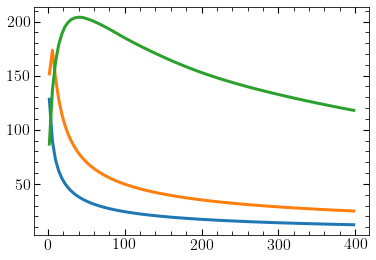

In [487]:
plot(xyz[0], vc_bulge)
plot(xyz[0], vc_disk)
plot(xyz[0], vc_halo)

In [40]:
mw_potential.G = 43007.1 * u.kpc * u.km**2 / u.s**2 / u.Msun / 1E10 

In [463]:
mw_a_bfe = mw_potential.acceleration(pos_mw_a[dcut_mw][:10000].T).to(u.kpc/u.Gyr**2).value


(array([78583., 14217.,  1476.,  1275.,   792.,   928.,   816.,   677.,
          645.,   591.]),
 array([  5.00004864,  54.49775201, 103.99545539, 153.49315876,
        202.99086213, 252.48856551, 301.98626888, 351.48397226,
        400.98167563, 450.479379  , 499.97708238]),
 <BarContainer object of 10 artists>)

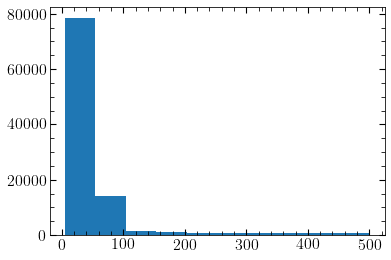

In [505]:
hist(dist_mw[dcut_mw][:100000])

In [585]:
mw_a_bfe2 = mw_potential.acceleration(pos_mw_a[dcut_mw][:1000000].T).to(u.kpc/u.Gyr**2).value


## TODO: Fix x-label axis

# Make this plot also at time 2 Gyrs

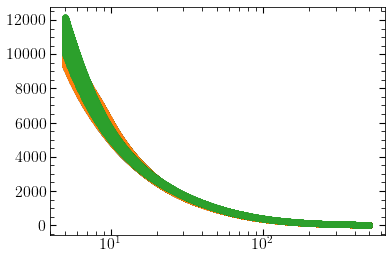

In [507]:
sort_d_mw = np.argsort(dist_mw[dcut_mw])
sort_d2_mw = np.argsort(dist_mw[dcut_mw][:100000])

scatter(dist_mw[dcut_mw][sort_d_mw], np.sqrt(np.sum(a_mw_fmm[dcut_mw]**2, axis=1))[sort_d_mw])
scatter(dist_mw[dcut_mw][sort_d_mw], np.sqrt(np.sum(a_mw_direct[dcut_mw]**2, axis=1))[sort_d_mw])
scatter(dist_mw[dcut_mw][sort_d2_mw], np.sqrt(np.sum(np.array(mw_a_bfe2)**2, axis=0))[sort_d2_mw])

xscale('log')

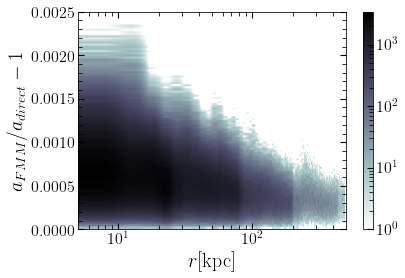

In [584]:
# 

a_dif_direct_fmm_mw = acceleration_diff(dist_mw[dcut_mw], a_mw_direct[dcut_mw], a_mw_fmm[dcut_mw], '/mnt/home/nico/Documents/gadget_mw_acc_errors_t1.6.png', [0, 2.5E-3],
                                       r'$a_{FMM} /a_{direct} - 1$')


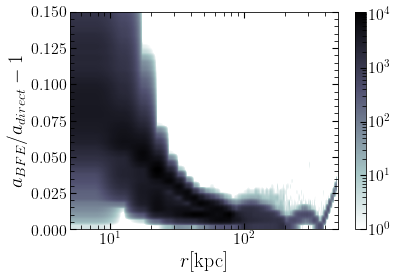

In [586]:
a_dif_direct_bfe_mw = acceleration_diff(dist_mw[dcut_mw][:1000000], a_mw_direct[dcut_mw][:1000000], mw_a_bfe2.T*0.956, 
                                        '/mnt/home/nico/Documents/gadget_mw_bfe_acc_errors_t1.6.png', [0, 0.15], r'$a_{BFE} /a_{direct} - 1$')


In [587]:
# Read coefficients

In [588]:
pos_mw_a[dcut_mw,1][0][:100000]

array([-5.15122307, -4.78935243, -6.47066493, ...,  9.05264243,
        8.99359875,  9.98833473])

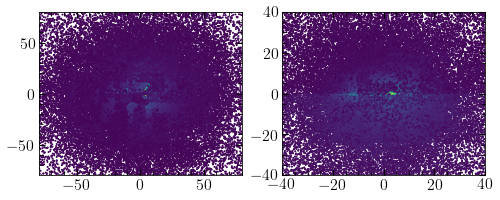

In [590]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].scatter(pos_mw_a[dcut_mw,0][0][:100000], pos_mw_a[dcut_mw,1][0][:100000], s=1, c=a_dif_direct_bfe_mw[:100000])
ax[0].set_xlim(-80, 80)
ax[0].set_ylim(-80, 80)

ax[1].scatter(pos_mw_a[dcut_mw,0][0][:100000], pos_mw_a[dcut_mw,2][0][:100000], s=1, c=a_dif_direct_bfe_mw[:100000])
ax[1].set_xlim(-40, 40)
ax[1].set_ylim(-40, 40)

savefig('/mnt/home/nico/Documents/MW_bfe_acc_errors_spatial_projection_t1.6.png', bbox_inches='tight')

In [32]:
np.shape(mw_a_bfe.T)

(100000, 3)

In [ ]:
#a_dif_direct_bfe_mw = acceleration_diff(dist_mw[dcut_mw], a_direct_mw[dcut_mw], a_bfe_.T[dcut], 'BFE_acc_errors.png', [0, 0.1])

In [ ]:
# Coefficients evolution 